In [1]:
import json
import re
import torch
import matplotlib.pyplot as plt

In [2]:
generator = torch.Generator().manual_seed(420)

In [3]:
# MLP

In [4]:
## Prepare the dataset

In [5]:
# Specifies the train/val/test split 
#(test will be inferred; it is just the remaining data)

train_split = 0.8
val_split = 0.1 

In [6]:
with open('../pokemons.json', 'r') as f:
    words = json.load(f)['names']

# remove weird characters from names
words = [re.sub(r'[^a-zA-Z]', '', word) for word in words]

# a character that serves as both start and end sentence token
special_token = "."

# prepare an alphabet: Set[str]
alphabet = list(set(''.join(words)))
alphabet.append(".")
alphabet.sort()

num_training_words = round(train_split * len(words))
num_validation_words = round(val_split * len(words))
num_test_words = len(words) - (num_training_words + num_validation_words)

training_words = words[:num_training_words]
validation_words = words[num_training_words:(num_validation_words + num_training_words)]
test_words = words[(num_validation_words + num_training_words):]

print(f"The dataset contains {len(words)} names.\n")

print(f"Choosing {len(training_words)} words for training.")
print(f"Choosing {len(validation_words)} words for validation.")
print(f"Choosing {len(test_words)} words for testing.\n")

print(f"Our alphabet consists of {len(alphabet)} characters: \n{alphabet}")

The dataset contains 908 names.

Choosing 726 words for training.
Choosing 91 words for validation.
Choosing 91 words for testing.

Our alphabet consists of 27 characters: 
['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
block_size = 3

In [8]:
def words_to_nn_dataset(words, block_size):
    inputs, labels = [], []
    for w in words:
        context = [alphabet.index(".")] * block_size
        for char in w + '.':
            idx = alphabet.index(char)
            inputs.append(context)
            labels.append(idx)
            context = context[1:] + [idx]
        
    return torch.tensor(inputs), torch.tensor(labels)

In [9]:
train_set = words_to_nn_dataset(training_words, block_size)
val_set = words_to_nn_dataset(validation_words, block_size)
test_set = words_to_nn_dataset(test_words, block_size)

In [10]:
class MLP:
    def __init__(self, train_set, 
                       val_set, 
                       test_set,
                       no_epochs,
                       embedding_size, 
                       hidden_layer, 
                       block_size, 
                       lr,
                       batch_size,
                       generator = generator):
        
        self.train_inputs, self.train_labels = train_set
        self.val_inputs, self.val_labels = val_set
        self.test_inputs, self.test_labels = test_set
        self.embedding_size = embedding_size
        self.hidden_layer = hidden_layer
        self.batch_size = batch_size
        self.no_epochs = no_epochs
        self.block_size = block_size
        self.lr = lr
        self.generator = generator
        

        self.C = torch.randn(len(alphabet), self.embedding_size, generator = self.generator)
        self.W1 = torch.randn((self.embedding_size * self.block_size), self.hidden_layer, generator = self.generator)
        self.b1 = torch.randn(self.hidden_layer,  generator = self.generator)
        self.W2 = torch.randn((self.hidden_layer, len(alphabet)),  generator = self.generator)
        self.b2 = torch.randn(len(alphabet),  generator = self.generator)
        
        self.params = [self.C, self.W1, self.b1, self.W2, self.b2]
        
        for p in self.params:
            p.requires_grad = True
        
    def compute_loss(self, inputs, outputs):
        inputs_onehot = torch.nn.functional.one_hot(inputs, len(alphabet))
        embeddings_in = torch.matmul(inputs_onehot.float(), self.C)
        embeddings_in = embeddings_in.view(-1, self.embedding_size * self.block_size)
        out = torch.tanh(embeddings_in @ self.W1 + self.b1) @ self.W2 + self.b2
        loss = torch.nn.functional.cross_entropy(out, outputs)
        return loss
    
    def visualize(self):
        
        assert self.embedding_size == 2
        plt.figure(figsize=(8,8))
        plt.scatter(self.C[:,0].data, self.C[:, 1].data, s =400)
        for i, char in enumerate(alphabet):
            plt.text(self.C[i,0].item(), self.C[i,1].item(), char, ha="center", va="center", color="white")
        
        
        
    def _forward(self, train=True):
        if train:
            minibatch_idx = torch.randint(self.train_inputs.size()[0], (self.batch_size,))
            minibatch = self.train_inputs[minibatch_idx]
            labels = self.train_labels[minibatch_idx]
        else:
            minibatch = self.val_inputs
            labels = self.val_labels
        
        loss = self.compute_loss(minibatch, labels)
        
        if train:
            for p in self.params:
                p.grad = None
                
            loss.backward()
            for p in self.params:
                p.data -= self.lr * p.grad
                
        return loss
    
    def evaluate(self, on_validation = False):
        if on_validation:
            return self.compute_loss(self.val_inputs, self.val_labels).item()
        return self.compute_loss(self.test_inputs, self.test_labels).item()
        
    
    def generate(self):
        old_char = "." * self.block_size
        new_char = None
        name = ""
        while new_char != ".":
            x = [alphabet.index(char) for char in old_char]
            x = torch.nn.functional.one_hot(torch.tensor(x), len(alphabet))
            x = x.float() @ self.C
            x = x.view(self.embedding_size * self.block_size)
            pseudo_probs = torch.nn.functional.softmax(torch.tanh(x @ self.W1 + self.b1) @ self.W2 + self.b2)
            sample=torch.multinomial(pseudo_probs, num_samples=1, replacement=True)
            new_char = alphabet[sample.item()]
            name += new_char
            old_char = old_char[1:] + new_char
        return name[:-1]
           
        
    def train(self, verbose = True):
        for epoch in range(self.no_epochs):
            training_loss = self._forward()
            validation_loss = self._forward(train=False)
            if epoch % 2000 == 0 and verbose:
                print(f"Epoch: {epoch}, Training loss: {training_loss.item()}, Validation loss: {validation_loss.item()}")
        
    
        
        

In [11]:
# Evaluate

In [12]:
mlp = MLP(train_set = train_set, 
          val_set = val_set, 
          test_set = test_set, 
          no_epochs = 30000, 
          embedding_size = 2, 
          block_size = block_size, 
          hidden_layer = 100,
          lr = 0.02,
          batch_size = 512,
          generator = generator)

mlp.train()
print(f"\nThe quality of the MLP (NLL): {mlp.evaluate()}")
mlp_names = [mlp.generate() for _ in range(10)]
print(f"\nNames generated by a mlp model:\n{mlp_names}")

            
            

Epoch: 0, Training loss: 15.75074291229248, Validation loss: 16.307416915893555
Epoch: 2000, Training loss: 2.9200141429901123, Validation loss: 3.028886556625366
Epoch: 4000, Training loss: 2.6818366050720215, Validation loss: 2.8806636333465576
Epoch: 6000, Training loss: 2.7254478931427, Validation loss: 2.845858097076416
Epoch: 8000, Training loss: 2.698960065841675, Validation loss: 2.8175501823425293
Epoch: 10000, Training loss: 2.597160577774048, Validation loss: 2.7981457710266113
Epoch: 12000, Training loss: 2.603267192840576, Validation loss: 2.7897074222564697
Epoch: 14000, Training loss: 2.6189301013946533, Validation loss: 2.783658027648926
Epoch: 16000, Training loss: 2.5152714252471924, Validation loss: 2.773317337036133
Epoch: 18000, Training loss: 2.590458631515503, Validation loss: 2.7674055099487305
Epoch: 20000, Training loss: 2.602492332458496, Validation loss: 2.764740467071533
Epoch: 22000, Training loss: 2.5834131240844727, Validation loss: 2.7614572048187256
Ep

/var/folders/vp/0hnkqfrn1gddm9svyn1vqxhw0000gn/T/ipykernel_18255/2639766651.py:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pseudo_probs = torch.nn.functional.softmax(torch.tanh(x @ self.W1 + self.b1) @ self.W2 + self.b2)


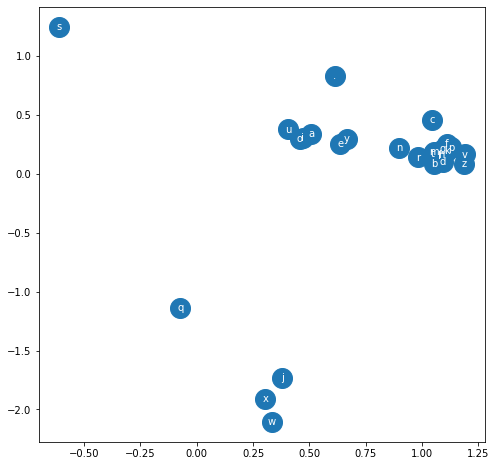

In [13]:
mlp.visualize()

In [15]:
block_size = 5
train_set = words_to_nn_dataset(training_words, block_size)
val_set = words_to_nn_dataset(validation_words, block_size)
test_set = words_to_nn_dataset(test_words, block_size)

mlp = MLP(train_set = train_set, 
          val_set = val_set, 
          test_set = test_set, 
          no_epochs = 30000, 
          embedding_size = 2, 
          block_size = block_size, 
          hidden_layer = 200,
          lr = 0.02,
          batch_size = 512,
          generator = generator)

mlp.train()
print(f"\nThe quality of the MLP (NLL): {mlp.evaluate()}")
mlp_names = [mlp.generate() for _ in range(10)]
print(f"\nNames generated by a mlp model:\n{mlp_names}")

Epoch: 0, Training loss: 21.792390823364258, Validation loss: 20.645870208740234
Epoch: 2000, Training loss: 2.7857160568237305, Validation loss: 2.8626670837402344
Epoch: 4000, Training loss: 2.6701173782348633, Validation loss: 2.7841289043426514
Epoch: 6000, Training loss: 2.589299440383911, Validation loss: 2.7586967945098877
Epoch: 8000, Training loss: 2.6442883014678955, Validation loss: 2.748828649520874
Epoch: 10000, Training loss: 2.5999011993408203, Validation loss: 2.7487845420837402
Epoch: 12000, Training loss: 2.603194236755371, Validation loss: 2.749021530151367
Epoch: 14000, Training loss: 2.575972557067871, Validation loss: 2.7414302825927734
Epoch: 16000, Training loss: 2.5208754539489746, Validation loss: 2.730646848678589
Epoch: 18000, Training loss: 2.552062511444092, Validation loss: 2.7386906147003174
Epoch: 20000, Training loss: 2.607815742492676, Validation loss: 2.7272543907165527
Epoch: 22000, Training loss: 2.597562789916992, Validation loss: 2.73435282707214

/var/folders/vp/0hnkqfrn1gddm9svyn1vqxhw0000gn/T/ipykernel_18255/2639766651.py:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pseudo_probs = torch.nn.functional.softmax(torch.tanh(x @ self.W1 + self.b1) @ self.W2 + self.b2)


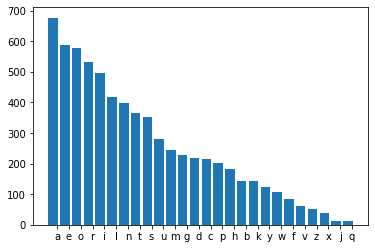

In [48]:
from collections import Counter
import numpy as np 

counts = Counter("".join(words))

labels, values = zip(*counts.items())

# sort your values in descending order
indSort = np.argsort(values)[::-1]

# rearrange your data
labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

bar_width = 0.35

plt.bar(indexes, values)

# add labels
plt.xticks(indexes + bar_width, labels)
plt.show()